<a href="https://colab.research.google.com/github/Txy822/practical-nlp-code/blob/master/PersonalityClassifierTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install TF Lite Model-Maker-easy to train models on a custom dataset and reduces time to train by using Transfer Learning on pre-trained models

In [ ]:
!pip install -q tflite-model-maker

     |████████████████████████████████| 591 kB 5.3 MB/s 
     |████████████████████████████████| 64 kB 3.2 MB/s 
     |████████████████████████████████| 596 kB 30.0 MB/s 
     |████████████████████████████████| 213 kB 59.1 MB/s 
     |████████████████████████████████| 1.2 MB 46.8 MB/s 
     |████████████████████████████████| 6.3 MB 30.6 MB/s 
     |████████████████████████████████| 120 kB 61.2 MB/s 
     |████████████████████████████████| 103 kB 71.6 MB/s 
     |████████████████████████████████| 840 kB 37.0 MB/s 
     |████████████████████████████████| 1.1 MB 66.9 MB/s 
     |████████████████████████████████| 87 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 57.2 MB/s 
     |████████████████████████████████| 47.6 MB 35 kB/s 
     |████████████████████████████████| 99 kB 8.7 MB/s 
     |████████████████████████████████| 352 kB 24.2 MB/s 
     |████████████████████████████████| 208 kB 62.9 MB/s 


Install necessary libraries.

In [ ]:
import numpy as np
from numpy.random import RandomState
import pandas as pd
import os

from tflite_model_maker import model_spec
from tflite_model_maker import text_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.text_classifier import AverageWordVecSpec
from tflite_model_maker.text_classifier import DataLoader

import tensorflow as tf
assert tf.__version__.startswith('2')
tf.get_logger().setLevel('ERROR')
# Data Analysis
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pickle as pkl
from scipy import sparse

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Text Processing
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Machine Learning packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.cluster as cluster
from sklearn.manifold import TSNE

# Model training and evaluation
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

Upload dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving mbti_1.csv to mbti_1.csv


Store dataset in pendas datafram




In [ ]:
import io
data_set = pd.read_csv(io.BytesIO(uploaded['mbti_1.csv']))
# Dataset is now stored in a Pandas Dataframe
data_set.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [ ]:
#Finding the most common words in all posts.
words = list(data_set["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(40)

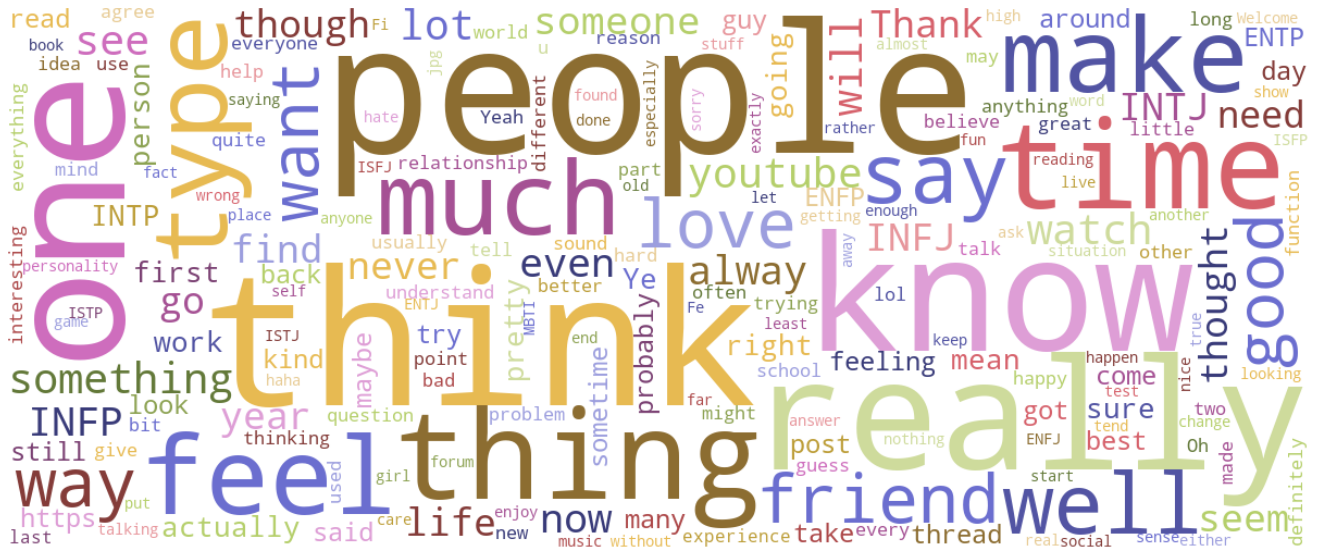

In [ ]:
#Plotting the most common words with WordCloud.
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))

# collocations to False  is set to ensure that the word cloud doesn't appear as if it contains any duplicate words
plt.figure(figsize=(25,10))
# generate word cloud, interpolation 
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

In [ ]:
fig, ax = plt.subplots(len(data_set['type'].unique()), sharex=True, figsize=(15,len(data_set['type'].unique())))
k = 0
for i in data_set['type'].unique():
    df_4 = data_set[data_set['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

In [ ]:
data_set.head()

In [ ]:
target.head()

In [ ]:
df=data_set

In [ ]:
def preprocess_text(df, remove_special=True):
    texts = df['posts'].copy()
    labels = df['type'].copy()

    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove MBTI Personality Words - crutial in order to get valid model accuracy estimation for unseen data. 
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")
    
    return df

#Preprocessing of entered Text
new_df = preprocess_text(data_set)

In [ ]:
#Remove posts with less than X words
min_words = 15
print("Before : Number of posts", len(new_df)) 
new_df["no. of. words"] = new_df["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["no. of. words"] >= min_words]

print("After : Number of posts", len(new_df))

Before : Number of posts 8675
After : Number of posts 8466


In [ ]:
new_df.head()

In [ ]:
# Converting MBTI personality (or target or Y feature) into numerical form using Label Encoding
# encoding personality type
enc = LabelEncoder()
data_set['type of encoding'] = enc.fit_transform(data_set['type'])

target = data_set['type of encoding'] 

In [ ]:
new_df.head()

Split the dataset to train and test

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
train, test = train_test_split(data_set, test_size=0.2)

In [ ]:
train_new, test_new = train_test_split(new_df, test_size=0.2)

Export the slit to csv file

In [ ]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [ ]:
train_new.to_csv('train_new.csv',index=False)
test_new.to_csv('test_new.csv',index=False)

In [ ]:
test_new.head()

,type,posts,no. of. words
7278,INFJ,find easy forgive eostokenquest very mu...,310
1192,ESTP,difficult tell sometimes eostokendot both...,1000
1920,INFP,shark this thing really taking long eost...,721
2128,INFP,ocarina time eostokenexs eostokenexs eostok...,195
2603,INTJ,what some unique bible verses that consider...,732


Choose a text classification model architecture

 There are some text classification  models like BERT, mobilebert and others.The average word embedding model architecture is chosen which will produce a small and fast model

In [ ]:
spec = model_spec.get('average_word_vec')
# spec = model_spec.get(‘mobilebert_classifier’)
# spec = model_spec.get(‘bert_classifier’)
# spec = AverageWordVecSpec(wordvec_dim = 32)

In [ ]:

train_data = DataLoader.from_csv(
      filename='train_new.csv',
      text_column='posts',
      label_column='type',
      model_spec=spec,
      is_training=True)

test_data = DataLoader.from_csv(
      filename='test_new.csv',
      text_column='posts',
      label_column='type',
      model_spec=spec,
      is_training=False)

In [ ]:
model = text_classifier.create(train_data, model_spec=spec, epochs=100)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 16)           160048    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
Total params: 160,592
Trainable params: 160,592
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss, acc = model.evaluate(test_data)

53/53 [==============================] - 0s 4ms/step - loss: 5.1082 - accuracy: 0.3200


In [ ]:
model.export(export_dir='average_word_vec')